In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd
import geopandas as gpd

In [7]:
path = '../../../GCrundirs/IRF_runs/mod_inputs/BC-em-anthro_CMIP_CEDS_2016'

In [8]:
ds = xr.open_dataset(path + '.nc', engine = "netcdf4")

In [10]:
ds

<xarray.Dataset> Size: 100MB
Dimensions:  (time: 12, lon: 720, lat: 360)
Coordinates:
  * time     (time) datetime64[ns] 96B 2016-01-01 2016-02-01 ... 2016-12-01
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Data variables:
    BC_agr   (time, lat, lon) float32 12MB ...
    BC_ene   (time, lat, lon) float32 12MB ...
    BC_ind   (time, lat, lon) float32 12MB ...
    BC_rco   (time, lat, lon) float32 12MB ...
    BC_shp   (time, lat, lon) float32 12MB ...
    BC_slv   (time, lat, lon) float32 12MB ...
    BC_tra   (time, lat, lon) float32 12MB ...
    BC_wst   (time, lat, lon) float32 12MB ...
Attributes: (12/37)
    CDI:                         Climate Data Interface version 1.9.4 (http:/...
    history:                     Thu Jun 24 17:01:55 2021: cdo selyear,2016 ....
    source:                      CEDS-2021-04-21: Community Emissions Data Sy...
    institution:                 Joint Global Change Research Institute, Paci...
    Conventions:                 CF-1.6
    activity_id:                 input4MIPs
    ...                          ...
    data_usage_tips:             Note that these are monthly average fluxes.
    reporting_unit:              Mass flux of BC, reported as carbon mass
    references:                  https://doi.org/10.25584/PNNLDataHub/1779095
    nco_openmp_thread_number:    1
    NCO:                         netCDF Operators version 4.7.4 (http://nco.s...
    CDO:                         Climate Data Operators version 1.9.4 (http:/...

In [9]:
sectors_pulsed = [#'BC_agr',
 'BC_ene',]
#  'BC_ind',
#  'BC_rco',
#  'BC_slv',
#  'BC_tra',
#  'BC_wst'
# ]


In [ ]:
doubled = False
high_pulse = False
addition = False
complex_test = True

if doubled and high_pulse == True:
    print('ERROR: select only one option')
if doubled and addition == True:
    print('ERROR: select only one option')
if addition and high_pulse == True:
    print('ERROR: select only one option')
if addition and complex_test == True:
    print('ERROR: select only one option')
if complex_test and high_pulse == True:
    print('ERROR: select only one option')
if doubled and complex_test == True:
    print('ERROR: select only one option')

In [4]:
if high_pulse == True:
    increase_amt = 15
if doubled == True:
    increase_amt = 1
if addition == True:
    increase_amt = 1e-12
if complex_test == True:
    increase_amt = 1e-12
#per grid box #kg/m2/s (15 if doing pulse (total of 16x), change to 1 if doing a 2x check simulation (total of 2x), 1e-12 if doing added simulation)

NameError: name 'high_pulse' is not defined

# Addition

## Regional

In [23]:
if addition == True:
    ### create a pulsed dataset
    pulse_ds =  ds.drop(['BC_ind',
                         'BC_rco',
                         'BC_slv',
                         'BC_tra',
                         'BC_wst',
                         'BC_shp', 
                         'BC_agr']).copy()
    pulse_ds = pulse_ds.fillna(0)#.round(12)
    pulse_ds += increase_amt

    ### import the regions we are interested in ###
    ar6_coal_location = pd.read_csv('ar6_coal_location.csv', index_col = 'number').to_dict()['acronym']


In [8]:
if addition == True:

    ### Global: Modify CEDs files
    regions = regionmask.defined_regions.ar6.land
    for r in ar6_coal_location.keys(): 
        ds_new = ds.copy()
        mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
        contiguous_mask = ~np.isnan(mask)& (mask == r)
        ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
        for sector in sectors_pulsed:
            ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output since that is our focus
            ds_new[sector].attrs = ds[sector].attrs
            fig, ax = plt.subplots()
            ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-12)
            plt.title(sector)
        ds_new.to_netcdf(path + '_' + ar6_coal_location[r] + f'_plus_{increase_amt}.nc')

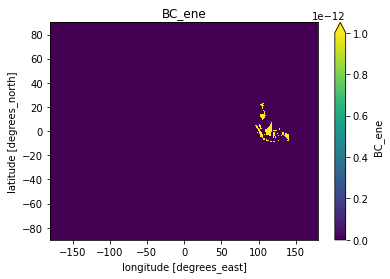

In [24]:
region_df = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
regions = regionmask.from_geopandas(region_df, names="NAME", abbrevs="_from_name", name="country")
if addition == True:
    ds_new = ds.copy()
    mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
    contiguous_mask = ~np.isnan(mask) & ((mask == regions['Cambodia'].number) | (mask == regions['Indonesia'].number) | (mask == regions[ 'Malaysia'].number) | (mask == regions[ 'Vietnam'].number))
    ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
    for sector in sectors_pulsed:
        ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output, but it doesn't matter which one is chosen as all grids get the same pulse
        ds_new[sector].attrs = ds[sector].attrs
        fig, ax = plt.subplots()
        ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-12)
        plt.title(sector)
    ds_new.to_netcdf(path + '_' + 'all_countries' + f'_plus_{increase_amt}.nc')



## Country Addition


In [9]:
if addition == True:

    region_df = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
    regions = regionmask.from_geopandas(region_df, names="NAME", abbrevs="_from_name", name="country")

In [10]:
if addition == True:

    for r in ['Cambodia', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore','Vietnam']: 
        ds_new = ds.copy()
        mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
        contiguous_mask = ~np.isnan(mask)& (mask == regions[r].number)
        ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
        for sector in sectors_pulsed:
            ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output
            ds_new[sector].attrs = ds[sector].attrs
            fig, ax = plt.subplots()
            ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-12)
            plt.title(sector)
        ds_new.to_netcdf(path + '_' + r + f'_plus_{increase_amt}.nc')



# Weighted Multiplication

## Regional

In [7]:
if doubled or high_pulse == True:
    ### create a pulsed dataset
    pulse_ds =  ds.drop(['BC_ind',
                         'BC_rco',
                         'BC_slv',
                         'BC_tra',
                         'BC_wst',
                         'BC_shp', 
                         'BC_agr']).copy()
    pulse_ds = pulse_ds*increase_amt


<xarray.DataArray 'BC_ene' ()>
array(1.8361838e-12, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-01
<xarray.DataArray 'BC_ene' ()>
array(1.3014682e-11, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-01
<xarray.DataArray 'BC_ene' ()>
array(1.6277012e-10, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-01
<xarray.DataArray 'BC_ene' ()>
array(2.6918769e-12, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-01
<xarray.DataArray 'BC_ene' ()>
array(1.6736352e-11, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-01
<xarray.DataArray 'BC_ene' ()>
array(1.9352176e-11, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-01
<xarray.DataArray 'BC_ene' ()>
array(1.0744817e-11, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-01
<xarray.DataArray 'BC_ene' ()>
array(3.1650108e-12, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-01
<xarray.DataArray 'BC_ene' ()>
array(2.7136566e-

/tmp/ipykernel_773/87591641.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<xarray.DataArray 'BC_ene' ()>
array(8.083189e-13, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-01
<xarray.DataArray 'BC_ene' ()>
array(2.0891807e-11, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-01
<xarray.DataArray 'BC_ene' ()>
array(7.188994e-11, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-01
<xarray.DataArray 'BC_ene' ()>
array(3.231743e-12, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-01
<xarray.DataArray 'BC_ene' ()>
array(2.5064907e-12, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-01
<xarray.DataArray 'BC_ene' ()>
array(7.921717e-12, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-01
<xarray.DataArray 'BC_ene' ()>
array(1.14570835e-11, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-01
<xarray.DataArray 'BC_ene' ()>
array(2.9149072e-11, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-01
<xarray.DataArray 'BC_ene' ()>
array(9.833088e-12, 

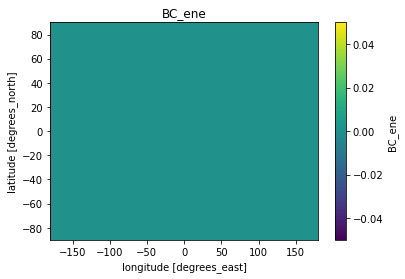

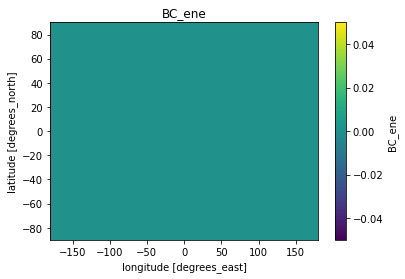

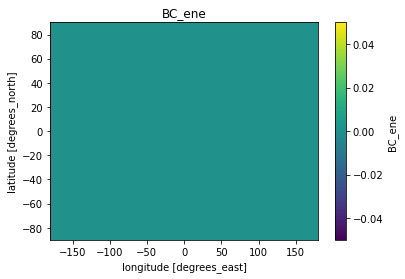

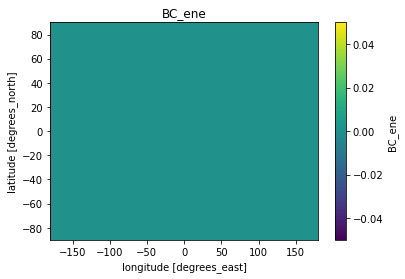

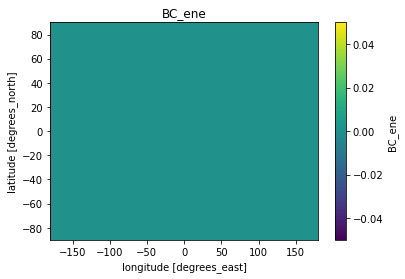

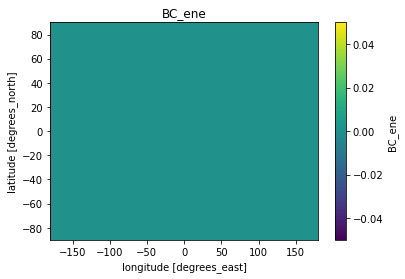

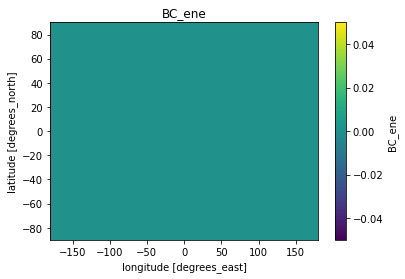

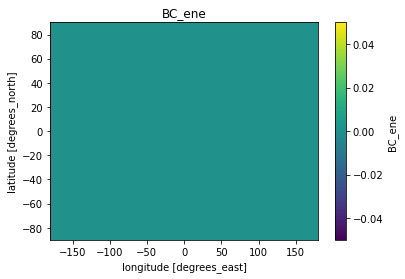

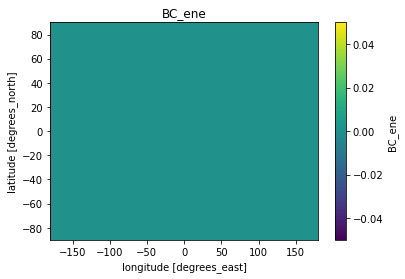

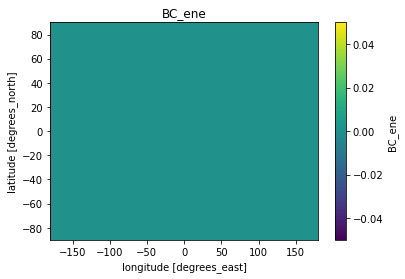

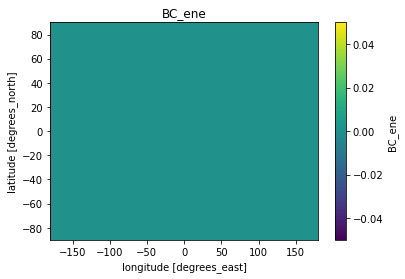

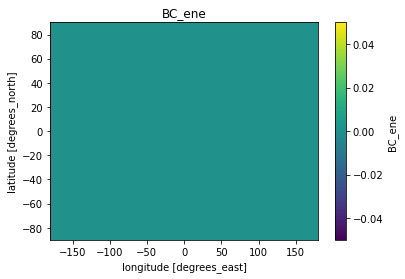

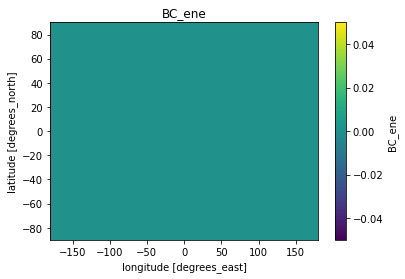

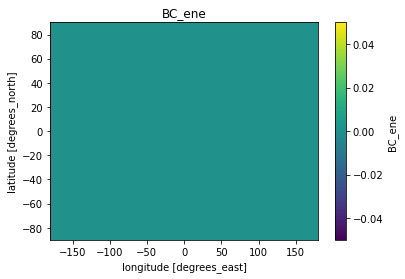

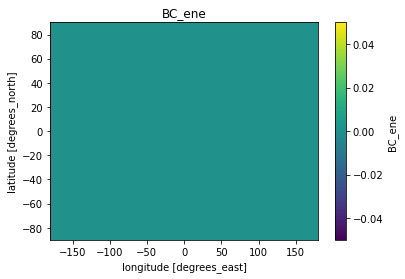

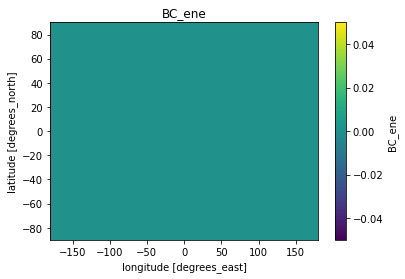

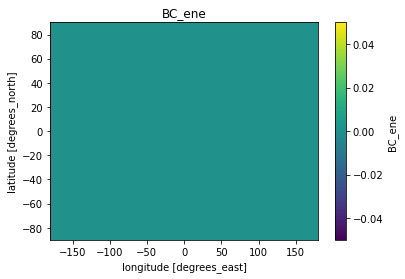

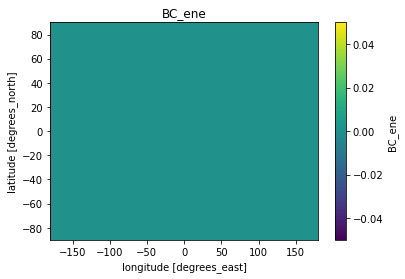

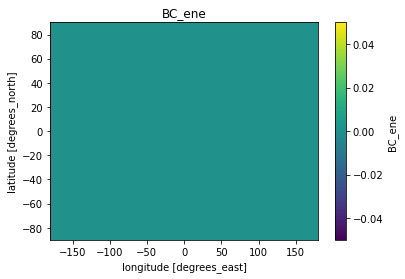

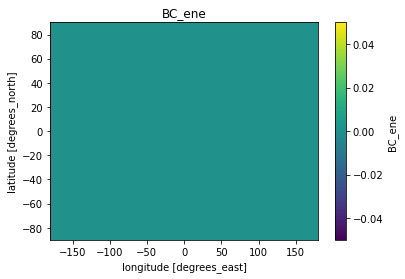

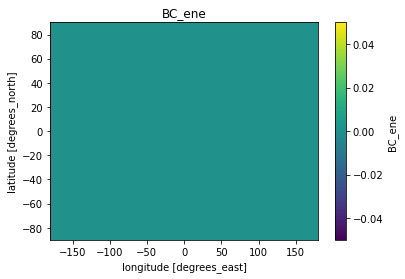

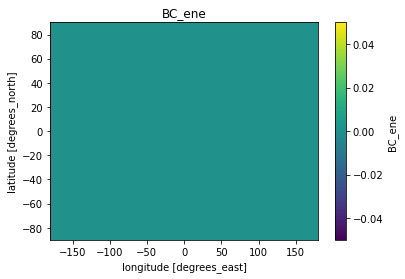

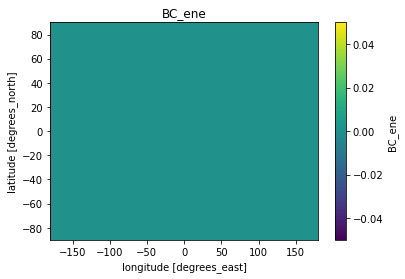

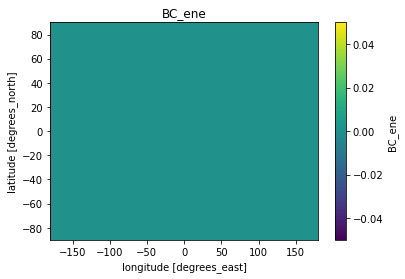

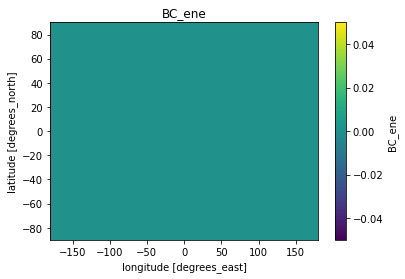

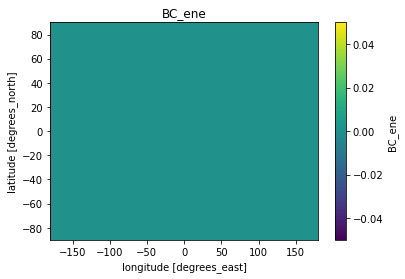

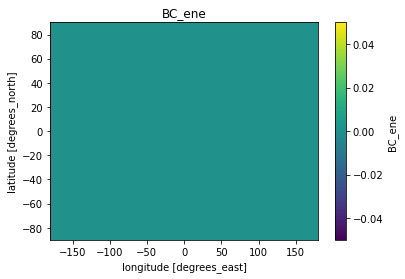

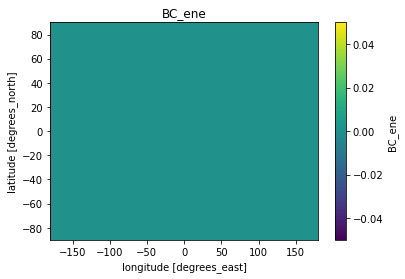

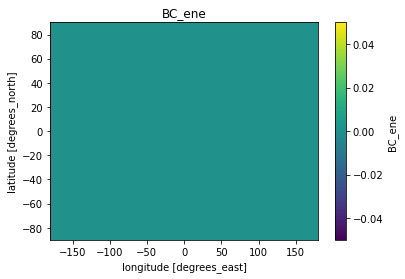

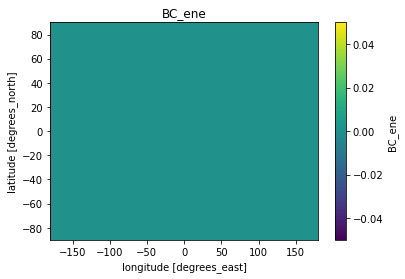

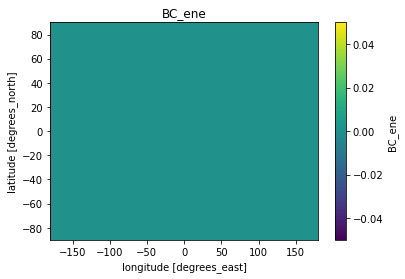

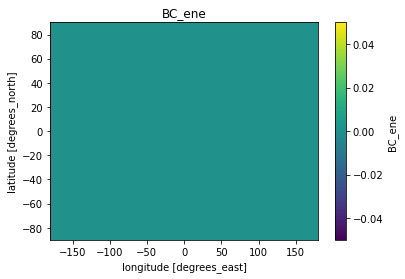

In [8]:
if doubled or high_pulse == True:

    ### import the regions we are interested in ###
    ar6_coal_location = pd.read_csv('ar6_coal_location.csv', index_col = 'number').to_dict()['acronym']
    
    
    ### Global: Modify CEDs files
    regions = regionmask.defined_regions.ar6.land
    for r in ar6_coal_location.keys(): 
        ds_new = ds.copy()
        mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
        contiguous_mask = ~np.isnan(mask)& (mask == r)
        ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
        for sector in sectors_pulsed:
            ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output, but it doesn't matter which one is chosen as all grids get the same pulse
            #since we add our pulse to the original, our prescribed 'increase_amt' is always 1x less than what we want as the final pulse
            ds_new[sector].attrs = ds[sector].attrs
            fig, ax = plt.subplots()
            ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, robust = True)
            print(((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).max())
            plt.title(sector)
        #ds_new.to_netcdf(path + '_' + ar6_coal_location[r] + f'_{increase_amt+1}x.nc')

## Country Specific

In [14]:
if doubled or high_pulse == True:

    region_df = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
    regions = regionmask.from_geopandas(region_df, names="NAME", abbrevs="_from_name", name="country")
    

4.715863e-13
4.8636928e-12
1.8112343e-12
1.09637e-12
0.0
1.71667e-12


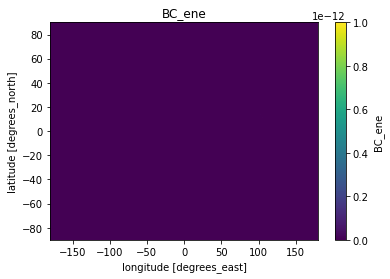

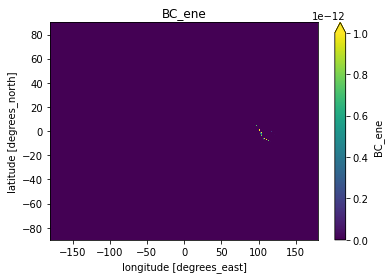

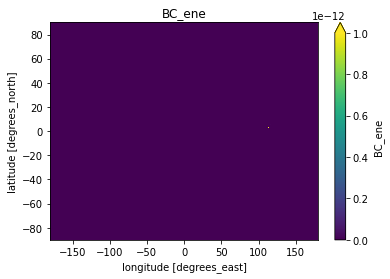

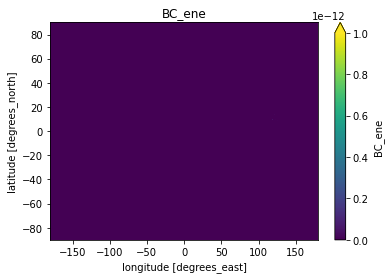

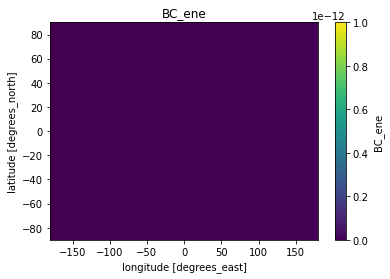

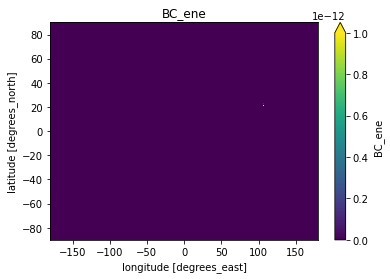

In [15]:
if doubled or high_pulse == True:
    
    for r in ['Cambodia', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore','Vietnam']: 
        ds_new = ds.copy()
        mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
        contiguous_mask = ~np.isnan(mask)& (mask == regions[r].number)
        ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
        for sector in sectors_pulsed:
            ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output, but it doesn't matter which one is chosen as all grids get the same pulse
            ds_new[sector].attrs = ds[sector].attrs
            fig, ax = plt.subplots()
            ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-12)
            print(((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).max().values)

            plt.title(sector)
       #ds_new.to_netcdf(path + '_' + r + f'_{increase_amt+1}x.nc')


## Country Specific choice of grid box for linearity (Indonesia)

In [16]:
if doubled or high_pulse == True:

    region_df = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
    regions = regionmask.from_geopandas(region_df, names="NAME", abbrevs="_from_name", name="country")
    

In [17]:
print(regions['Indonesia'].bounds)
print(regions['Indonesia'].centroid)

(95.01270592500003, -10.922621351999908, 140.97762699400005, 5.910101630000042)
[114.01880911  -0.19135808]


95.01270592500003 8
140.97762699400005 -5
114.01880910588372 -0.1913580795447946


(-20.0, 10.0)

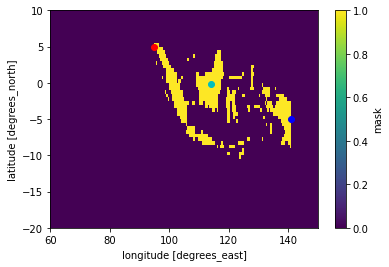

In [18]:
#choice of locations to pulse:

mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
contiguous_mask = ~np.isnan(mask)& (mask == regions['Indonesia'].number)
contiguous_mask.plot()
plt.plot(95,5,'ro')#(regions['Indonesia'].bounds[0], 8, 'ro')
print(regions['Indonesia'].bounds[0], 8)
plt.plot(regions['Indonesia'].bounds[2], -5, 'bo')
print(regions['Indonesia'].bounds[2], -5)
plt.plot(regions['Indonesia'].centroid[0], regions['Indonesia'].centroid[1], 'co')
print(regions['Indonesia'].centroid[0], regions['Indonesia'].centroid[1])
plt.xlim(60,150)
plt.ylim(-20,10)

95.01270592500003 8
140.97762699400005 -5
114.01880910588372 -0.1913580795447946


(-20.0, 10.0)

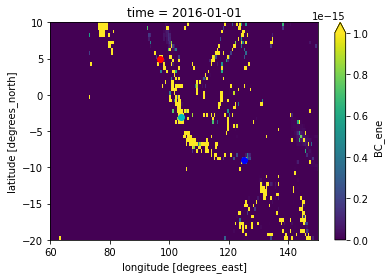

In [19]:
#choice of locations to pulse:

pulse_ds['BC_ene'].isel(time = 0).plot(vmax = 1e-15)
plt.plot(97,5,'ro')#(regions['Indonesia'].bounds[0], 8, 'ro')
print(regions['Indonesia'].bounds[0], 8)
plt.plot(125, -9, 'bo')
print(regions['Indonesia'].bounds[2], -5)
plt.plot(104, -3, 'co')
print(regions['Indonesia'].centroid[0], regions['Indonesia'].centroid[1])
plt.xlim(60,150)
plt.ylim(-20,10)

3.095011e-12
2.5344913e-15
2.2033241e-12


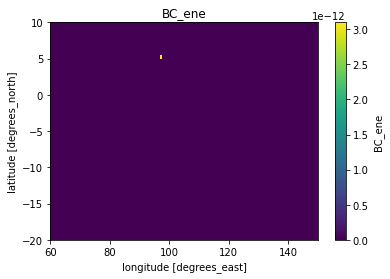

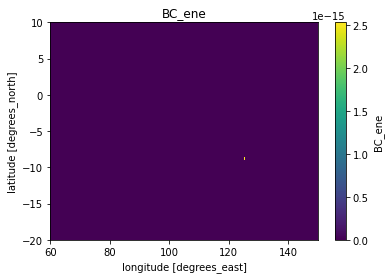

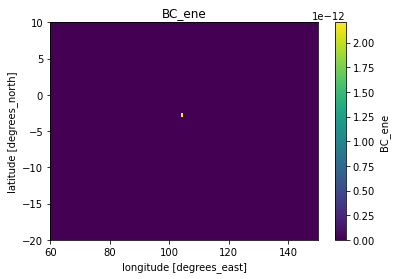

In [20]:
## Pulse at the bounds and centroid

if doubled or high_pulse == True:
    
    for lon, lat, loc in zip([97, 125, 104], [5,-9,-3], ['NW','Center','SE']):
        ds_new = ds.copy()
        ds_pulse_reg = pulse_ds.sel(lat = lat, lon = lon, method = 'nearest') #create a mask on our pulsed dataset
        for sector in sectors_pulsed:
            new_dat = ds_new[sector].loc[dict(lat=ds_pulse_reg.lat, lon=ds_pulse_reg.lon)] *(increase_amt +1) #ds.where((ds.lat==ds_pulse_reg.lat.values) & (ds.lon==ds_pulse_reg.lon.values), drop = True)* 2
            ds_new[sector].loc[dict(lat=ds_pulse_reg.lat, lon=ds_pulse_reg.lon)] = new_dat
            ds_new[sector].attrs = ds[sector].attrs
            fig, ax = plt.subplots()
            ds = xr.open_dataset(path + '.nc', engine = "netcdf4")
            ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax)
            print(((ds_new[sector]-ds[sector]).isel(time = 0)).max().values)
            plt.xlim(60,150)
            plt.ylim(-20,10)
            plt.title(sector)
        #ds_new.to_netcdf(path + '_' + 'Indo' + str(loc) + f'_{increase_amt+1}x.nc')


## All country for linearity

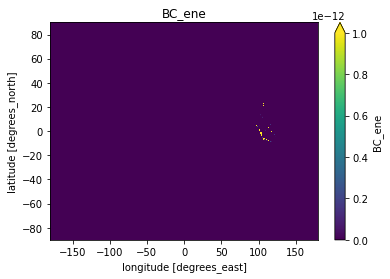

In [12]:
if doubled or high_pulse == True:
    ds_new = ds.copy()
    mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
    contiguous_mask = ~np.isnan(mask) & ((mask == regions['Cambodia'].number) | (mask == regions['Indonesia'].number) | (mask == regions[ 'Malaysia'].number) | (mask == regions[ 'Vietnam'].number))
    ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
    for sector in sectors_pulsed:
        ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output, but it doesn't matter which one is chosen as all grids get the same pulse
        ds_new[sector].attrs = ds[sector].attrs
        fig, ax = plt.subplots()
        ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-12)
        plt.title(sector)
    ds_new.to_netcdf(path + '_' + 'all_countries' + f'_{increase_amt+1}x.nc')



In [48]:
## NOTE-- Singapore does not have any difference when just the energy is pulsed ##

## check the various patterns of emissions w/ other sectors

In [72]:
ds_r = {}
for r in ['Cambodia', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore','Vietnam']: 
    ds_r[r] = xr.open_dataset(path + '_' + r + f'_{increase_amt}x_{sector}.nc')

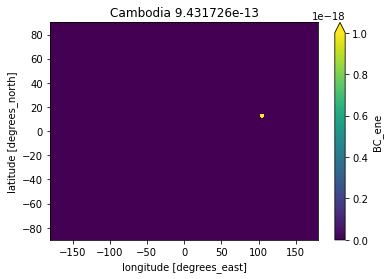

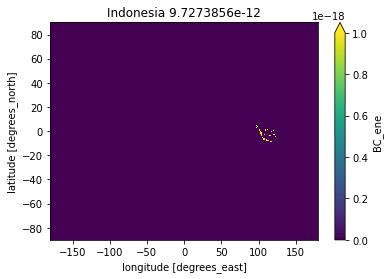

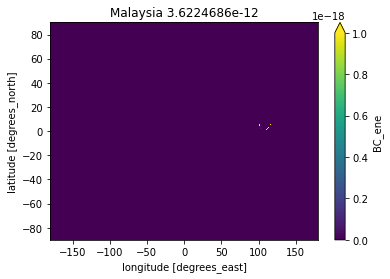

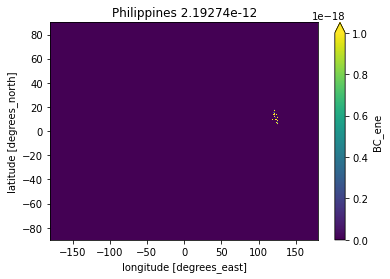

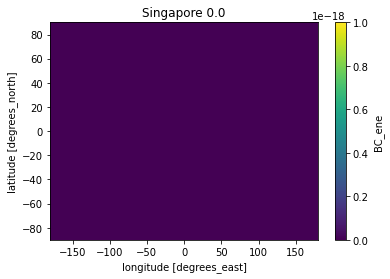

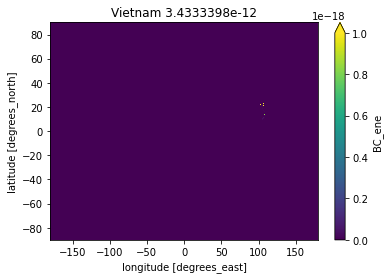

In [81]:
for r in ['Cambodia', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore','Vietnam']: 

    fig, ax = plt.subplots()
    ((ds_r[r][sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-18)
    plt.title(r + ' ' + str(((ds_r[r][sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).values.max()))

# Complex test-- Sin and Cosin

In [42]:
if complex_test == True:
    ds_interp = ds.resample(time="1D").interpolate("linear")
    HH = np.arange(0,len(ds_interp['time']))
    increase_amt = (1+np.cos((HH-12)/24*2*np.pi))/2
    increase_amt = xr.DataArray(data = increase_amt,
                dims = ['time'],
            coords = dict(time = ds_interp['time']))

In [50]:
increase_amt

<xarray.DataArray (time: 336)>
array([0.        , 0.01703709, 0.0669873 , 0.14644661, 0.25      ,
       0.37059048, 0.5       , 0.62940952, 0.75      , 0.85355339,
       0.9330127 , 0.98296291, 1.        , 0.98296291, 0.9330127 ,
       0.85355339, 0.75      , 0.62940952, 0.5       , 0.37059048,
       0.25      , 0.14644661, 0.0669873 , 0.01703709, 0.        ,
       0.01703709, 0.0669873 , 0.14644661, 0.25      , 0.37059048,
       0.5       , 0.62940952, 0.75      , 0.85355339, 0.9330127 ,
       0.98296291, 1.        , 0.98296291, 0.9330127 , 0.85355339,
       0.75      , 0.62940952, 0.5       , 0.37059048, 0.25      ,
       0.14644661, 0.0669873 , 0.01703709, 0.        , 0.01703709,
       0.0669873 , 0.14644661, 0.25      , 0.37059048, 0.5       ,
       0.62940952, 0.75      , 0.85355339, 0.9330127 , 0.98296291,
       1.        , 0.98296291, 0.9330127 , 0.85355339, 0.75      ,
       0.62940952, 0.5       , 0.37059048, 0.25      , 0.14644661,
       0.0669873 , 0.01703709, 0.        , 0.01703709, 0.0669873 ,
       0.14644661, 0.25      , 0.37059048, 0.5       , 0.62940952,
       0.75      , 0.85355339, 0.9330127 , 0.98296291, 1.        ,
       0.98296291, 0.9330127 , 0.85355339, 0.75      , 0.62940952,
       0.5       , 0.37059048, 0.25      , 0.14644661, 0.0669873 ,
       0.01703709, 0.        , 0.01703709, 0.0669873 , 0.14644661,
...
       0.        , 0.01703709, 0.0669873 , 0.14644661, 0.25      ,
       0.37059048, 0.5       , 0.62940952, 0.75      , 0.85355339,
       0.9330127 , 0.98296291, 1.        , 0.98296291, 0.9330127 ,
       0.85355339, 0.75      , 0.62940952, 0.5       , 0.37059048,
       0.25      , 0.14644661, 0.0669873 , 0.01703709, 0.        ,
       0.01703709, 0.0669873 , 0.14644661, 0.25      , 0.37059048,
       0.5       , 0.62940952, 0.75      , 0.85355339, 0.9330127 ,
       0.98296291, 1.        , 0.98296291, 0.9330127 , 0.85355339,
       0.75      , 0.62940952, 0.5       , 0.37059048, 0.25      ,
       0.14644661, 0.0669873 , 0.01703709, 0.        , 0.01703709,
       0.0669873 , 0.14644661, 0.25      , 0.37059048, 0.5       ,
       0.62940952, 0.75      , 0.85355339, 0.9330127 , 0.98296291,
       1.        , 0.98296291, 0.9330127 , 0.85355339, 0.75      ,
       0.62940952, 0.5       , 0.37059048, 0.25      , 0.14644661,
       0.0669873 , 0.01703709, 0.        , 0.01703709, 0.0669873 ,
       0.14644661, 0.25      , 0.37059048, 0.5       , 0.62940952,
       0.75      , 0.85355339, 0.9330127 , 0.98296291, 1.        ,
       0.98296291, 0.9330127 , 0.85355339, 0.75      , 0.62940952,
       0.5       , 0.37059048, 0.25      , 0.14644661, 0.0669873 ,
       0.01703709])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2016-12-01

4.863692781853501e-12


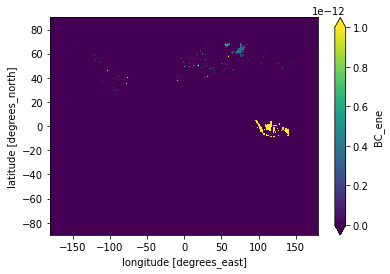

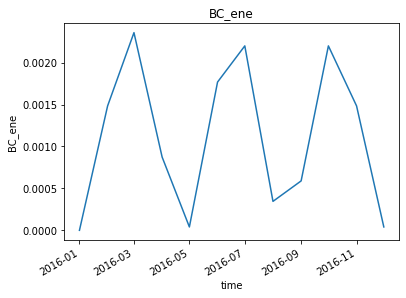

In [51]:
if complex_test == True:
    ### create a pulsed dataset
    pulse_ds =  ds_interp.drop(['BC_ind',
                         'BC_rco',
                         'BC_slv',
                         'BC_tra',
                         'BC_wst',
                         'BC_shp', 
                         'BC_agr']).copy()
    pulse_ds = pulse_ds.fillna(0)#.round(12)
    pulse_ds += increase_amt

    ### import the regions we are interested in ###
    ar6_coal_location = pd.read_csv('ar6_coal_location.csv', index_col = 'number').to_dict()['acronym']

    region_df = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
    regions = regionmask.from_geopandas(region_df, names="NAME", abbrevs="_from_name", name="country")
    
    for r in ['Indonesia']: 
        ds_new = ds_interp.copy()
        mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
        contiguous_mask = ~np.isnan(mask)& (mask == regions[r].number)
        ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
        for sector in sectors_pulsed:
            ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output, but it doesn't matter which one is chosen as all grids get the same pulse
            ds_new[sector].attrs = ds[sector].attrs
            fig, ax = plt.subplots()
            ((ds_new[sector]).isel(time = 1)-(ds[sector]).isel(time = 1)).plot(ax = ax)
            print(((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).max().values)
            fig, ax = plt.subplots()
            ((ds_new[sector])-(ds[sector])).mean(dim = ['lat','lon']).plot(ax = ax)
            plt.title(sector)
        ds_new.to_netcdf(path + '_' + r + f'_cos.nc')


## Interpolate base

In [ ]:
ds_base_interp= ds.resample(time="1D").interpolate("linear")

ds_base_interp.to_netcdf(path + 'interp_base' + '.nc')